# BISP01_conversation

Adapted from HyPyP Guillaume Dumas, Anaël Ayrolles, Florence Brun

Date : 2022-11-03

## Load useful libs

### Core

In [135]:
import io
from copy import copy
from collections import OrderedDict
import requests

### Data science

In [136]:
import numpy as np
import scipy

### Visualization

In [137]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from hypyp.ext.mpl3d import glm
from hypyp.ext.mpl3d.mesh import Mesh
from hypyp.ext.mpl3d.camera import Camera

### MNE

In [138]:
import mne

### HyPyP

In [139]:
from hypyp import prep 
from hypyp import analyses
from hypyp import stats
from hypyp import viz

### Setting parameters
Frequency bands used in the study

In [140]:
freq_bands = {'Delta':[2,3.5],
              'Theta':[4,7.5]}

#              'Alpha-Low': [7.5, 11],
 #             'Alpha-High': [11.5, 13],
  #           'Beta':[13,24.5],
   #          'Gamma':[25,45]}
              
full_freq = { 'full_frq': [1, 48]}

In [141]:
#Choose Frequency to do the sinchronization
data = {'Delta': [2, 3.5], 'Theta': [4, 7.5]}

# Access the first value (4) of Theta
hyp_band_low = freq_bands['Theta'][0]
hyp_band_high = freq_bands['Theta'][1]

hyp_band_low,hyp_band_high

(4, 7.5)

Keep the order of frequency bands in the dictionary

In [142]:
freq_bands = OrderedDict(freq_bands)

### Load data
Loading datasets (see MNE functions mne.io.read_raw_format), convert them to MNE Epochs.

In our example, we load Epochs directly from EEG dataset in the fiff format

In [143]:
raw1 = mne.io.read_raw_edf("BISP01_shaman_conversation_ok.edf")
raw2 = mne.io.read_raw_edf("BISP01_patient_conversation_ok.edf")

def process_raw(raw):
    # Load the data into memory
    raw.load_data()

    print(f"Shape of data: {raw._data.shape}")
    print(f"Sampling frequency: {raw.info['sfreq']} Hz")

    # Define channels to drop
    #ch_drop = ['CP5-N', 'Pz-N']

    # Drop the specified channels
    #raw.drop_channels(ch_drop, on_missing='raise')

    # Set the montage to 10-20 system
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(ten_twenty_montage)

    print("Channel names after 10-20 montage:")
    print(raw.info['ch_names'])

    # Set the montage to easycap-M1
    raw.set_montage('easycap-M1')

    print("Final channel names:")
    print(raw.info['ch_names'])

    return raw

raw_list = [raw1, raw2]

for i, raw in enumerate(raw_list, 1):
    print(f"\nProcessing raw{i}:")
    print("Initial info keys:")
    print(raw.info.keys())
    print("Initial channel names:")
    print(raw.info['ch_names'])

    processed_raw = process_raw(raw)
    
    # Here you can do additional processing or save the processed data
    # For example:
    # processed_raw.save(f'processed_raw{i}.fif', overwrite=True)

epo1 = mne.make_fixed_length_epochs(raw1,preload=True)
epo2 = mne.make_fixed_length_epochs(raw2,preload=True)


print("\nProcessing completed for all Raw objects.")

Extracting EDF parameters from /Users/cccbauer/Dropbox (MIT)/00_2022/ResearchScientist/0_PenLab/10_collaborations/EEG:Psilocybe/HyPyP/BISP01_shaman_conversation_ok.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/cccbauer/Dropbox (MIT)/00_2022/ResearchScientist/0_PenLab/10_collaborations/EEG:Psilocybe/HyPyP/BISP01_patient_conversation_ok.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

Processing raw1:
Initial info keys:
dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t',

In [144]:
raw1 = mne.io.read_raw_edf("BISP01_shaman_conversation_ok.edf")
raw2 = mne.io.read_raw_edf("BISP01_patient_conversation_ok.edf")

raw1.load_data()


Extracting EDF parameters from /Users/cccbauer/Dropbox (MIT)/00_2022/ResearchScientist/0_PenLab/10_collaborations/EEG:Psilocybe/HyPyP/BISP01_shaman_conversation_ok.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/cccbauer/Dropbox (MIT)/00_2022/ResearchScientist/0_PenLab/10_collaborations/EEG:Psilocybe/HyPyP/BISP01_patient_conversation_ok.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9727  =      0.000 ...    75.992 secs...


Measurement date,"March 26, 2023 15:10:35 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,31 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,0.00 Hz
Lowpass,64.00 Hz


Since our example dataset was not initially dedicated to hyperscanning, we need to equalize the number of epochs between our two participants.

In [145]:
mne.epochs.equalize_epoch_counts([epo1, epo2])

Dropped 16 epochs: 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75
Dropped 0 epochs: 


Specify sampling frequency

In [146]:
sampling_rate = epo1.info['sfreq']

## Preprocessing epochs
## ICA correction

Computing global AutoReject and Independant Components Analysis for each participant

In [147]:
icas = prep.ICA_fit([epo1, epo2],
                    n_components=15,
                    method='infomax',
                    fit_params=dict(extended=True),
                    random_state= 42)

Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 0.00015778615556407392}
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA


/opt/anaconda3/lib/python3.11/site-packages/hypyp/prep.py:181: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  random_state=random_state).fit(epoch)


Fitting ICA took 2.5s.
    Rejecting  epoch based on EEG : ['FT9', 'PO9', 'PO10', 'FCz']
    Rejecting  epoch based on EEG : ['FT9', 'P7', 'PO9', 'O1', 'PO10', 'Fp2']
    Rejecting  epoch based on EEG : ['P7', 'PO9', 'Oz', 'O2', 'PO10', 'CP6', 'F8', 'Fp2', 'FCz']
    Rejecting  epoch based on EEG : ['P7', 'PO9', 'PO10', 'FCz']
    Rejecting  epoch based on EEG : ['P7', 'PO9', 'PO10']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'C3', 'FT9', 'PO9', 'O2', 'PO10', 'F8', 'FCz']
    Rejecting  epoch based on EEG : ['PO9', 'PO10', 'F8', 'FCz']
    Rejecting  epoch based on EEG : ['FT9', 'P7', 'PO9', 'O2', 'PO10', 'CP2', 'CP6', 'FT10']
    Rejecting  epoch based on EEG : ['T7', 'P7', 'PO9', '

/opt/anaconda3/lib/python3.11/site-packages/hypyp/prep.py:186: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  icas.append(ica.fit(epoch_all_ch))


Fitting ICA took 1.5s.
Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 7.879366457225713e-05}
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA


/opt/anaconda3/lib/python3.11/site-packages/hypyp/prep.py:181: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  random_state=random_state).fit(epoch)


Fitting ICA took 2.6s.
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['F7', 'PO9', 'F8']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['F7', 'FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['PO9']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'F3', 'FC1', 'Oz', 'O2', 'PO10', 'T8', 'FT10', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['PO10', 'FT10']
    Rejecting  epoch based on EEG : ['O2', 'P8']
    Rejecting  epoch based on EEG : ['O2', 'P8']
    Rejecting  epoch based on EEG : ['PO9', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['F7', 'F3', 'F4']
    Rejecting  epoch based on EEG : ['PO9']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'F3', 'F8']
  

/opt/anaconda3/lib/python3.11/site-packages/hypyp/prep.py:186: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  icas.append(ica.fit(epoch_all_ch))


Fitting ICA took 2.4s.


Selecting relevant Independant Components for artefact rejection on one participant, that will be transpose to the other participant and removing them for both.

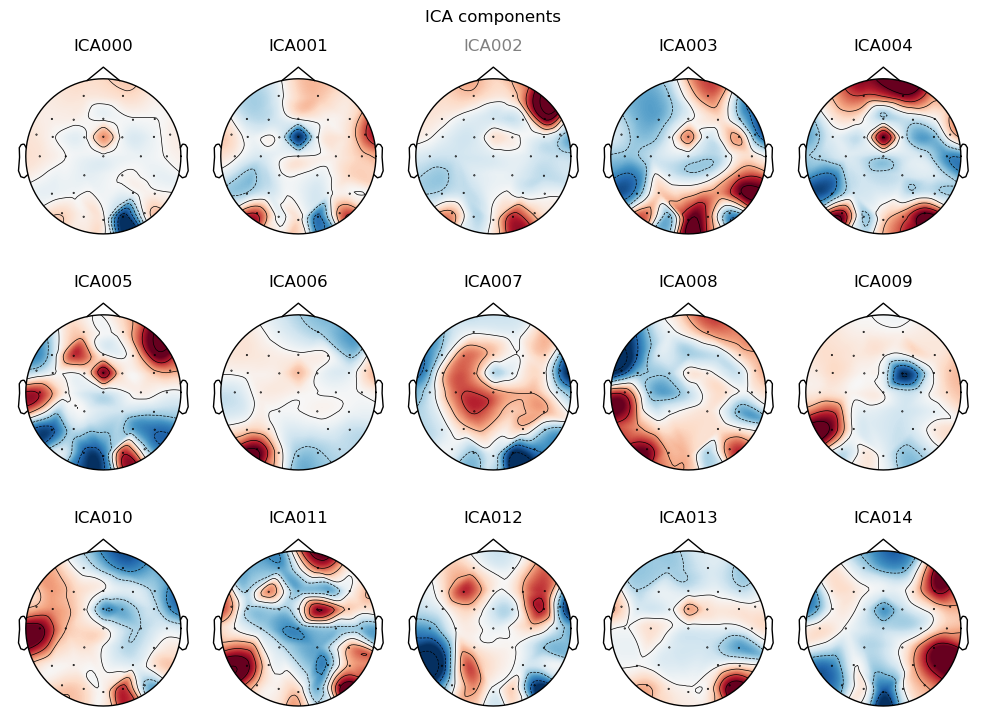

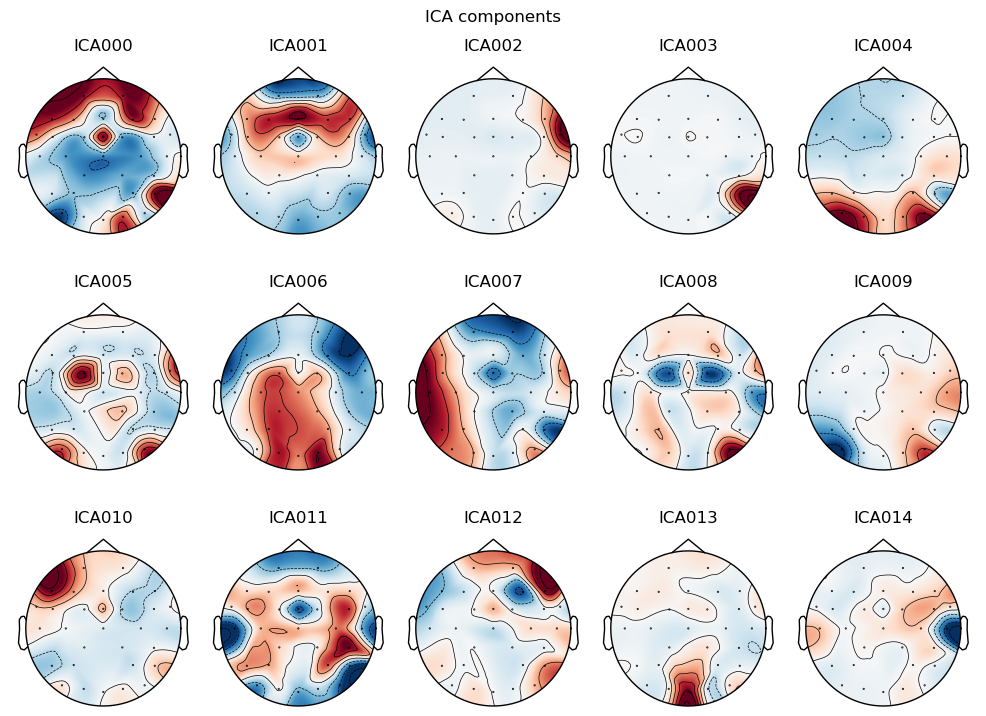

Which participant ICA do you want to use as a template for artifact rejection? Index begins at zero. (If you do not want to apply ICA on your data, do not enter nothing and press enter.)0
Which IC do you want to use as a template? Index begins at zero. (If you did not choosea participant number at first question,then do not enter nothing and press enter againto not apply ICA on your data)2


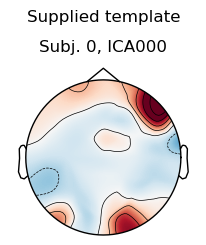

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.


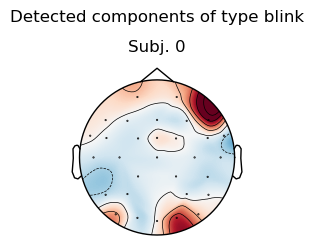

[{'blink': [2]}, {'blink': []}]
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 31 PCA components


In [149]:
cleaned_epochs_ICA = prep.ICA_choice_comp(icas, [epo1, epo2])

You can also use the mne-icalabel to automatically detect the not brain related components. Since this library depends on machine learning frameworks with complicated dependancies, we did not include it in the base requirements of HyPyP. If you want to test this automated approach of ICA annotation, just install it using ```pip install mne-icalabel``` and use the function below:

```python
from mne_icalabel import label_components

def ICA_autocorrect(icas: list, epochs: list, verbose: bool = False) -> list:
    """
    Automatically detect the ICA components that are not brain related and remove them.

    Arguments:
        icas: list of Independent Components for each participant (IC are MNE
          objects).
        epochs: list of 2 Epochs objects (for each participant). Epochs_S1
          and Epochs_S2 correspond to a condition and can result from the
          concatenation of Epochs from different experimental realisations
          of the condition.
          Epochs are MNE objects: data are stored in an array of shape
          (n_epochs, n_channels, n_times) and parameters information is
          stored in a disctionnary.
        verbose: option to plot data before and after ICA correction, 
          boolean, set to False by default. 

    Returns:
        cleaned_epochs_ICA: list of 2 cleaned Epochs for each participant
          (the non-brain related IC have been removed from the signal).
    """

    cleaned_epochs_ICA = []
    for ica, epoch in zip(icas, epochs):
        ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
        ica_with_labels_component_detected = ica_with_labels_fitted["labels"]
        # Remove non-brain components (take only brain components for each subject)
        excluded_idx_components = [idx for idx, label in enumerate(ica_with_labels_component_detected) if label not in ["brain"]]
        cleaned_epoch_ICA = mne.Epochs.copy(epoch)
        cleaned_epoch_ICA.info['bads'] = []
        ica.apply(cleaned_epoch_ICA, exclude=excluded_idx_components)
        cleaned_epoch_ICA.info['bads'] = copy.deepcopy(epoch.info['bads'])
        cleaned_epochs_ICA.append(cleaned_epoch_ICA)

        if verbose:
            epoch.plot(title='Before ICA correction', show=True)
            cleaned_epoch_ICA.plot(title='After ICA correction',show=True)
    return cleaned_epochs_ICA

cleaned_epochs_ICA = ICA_autocorrect(icas, [epo1, epo2], verbose=True)
```

For using PDC measure (Partial Coherence Connectivity), we should use the data that no ICA algorithm is applied on them.

In [150]:
# without ICA -> computing PDC based on MVARICA approach
cleaned_epochs_no_ICA = [epo1, epo2]

### Autoreject
Applying local AutoReject for each participant rejecting bad epochs, rejecting or interpolating partially bad channels removing the same bad channels and epochs across participants plotting signal before and after (verbose=True)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/31 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/31 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/mne/bem.py:1133: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.20 and n_interpolate=4
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/31 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/31 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/mne/bem.py:1133: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=4
Dropped 59 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59


  0%|          | Repairing epochs : 0/1 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 59 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59


  0%|          | Repairing epochs : 0/1 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
98.33333333333333 percent of bad epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


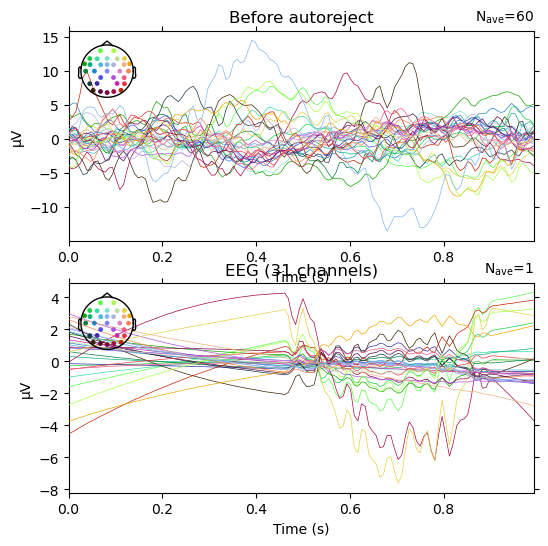

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

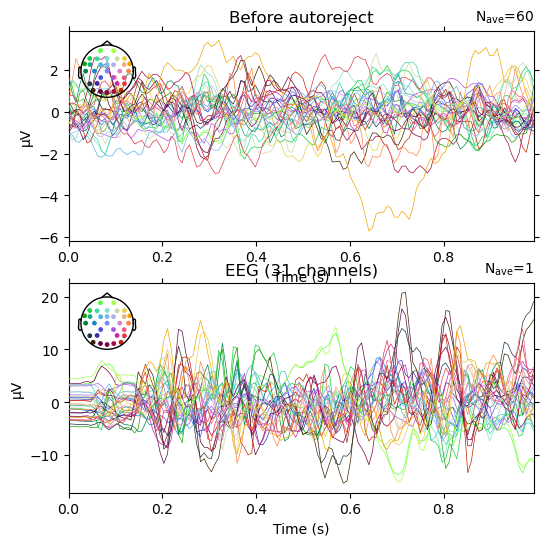

<Figure size 640x480 with 0 Axes>

In [151]:
# with ICA

cleaned_epochs_AR, dic_AR = prep.AR_local(cleaned_epochs_ICA,
                                          strategy="union",
                                          threshold=50.0,
                                          verbose=True
)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/31 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/31 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/mne/bem.py:1133: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=4
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/31 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/31 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/mne/bem.py:1133: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=4
Dropped 56 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59


  0%|          | Repairing epochs : 0/4 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 56 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59


  0%|          | Repairing epochs : 0/4 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
93.33333333333333 percent of bad epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


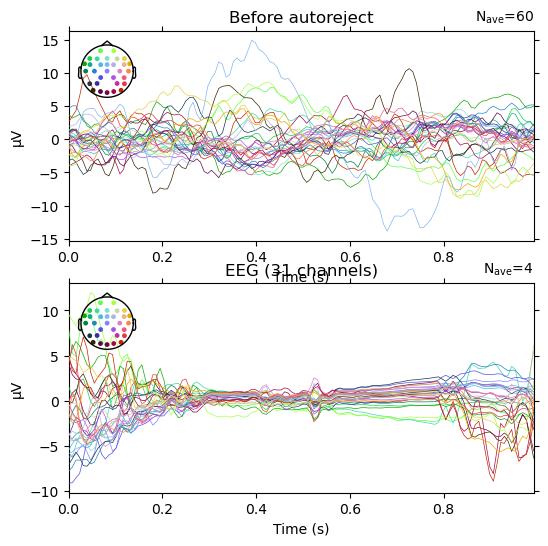

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

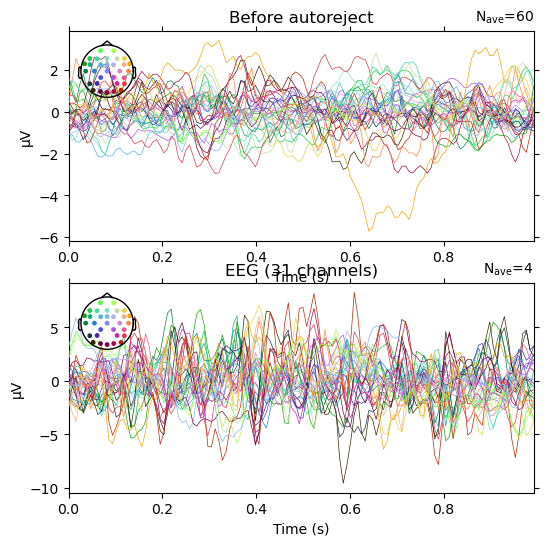

<Figure size 640x480 with 0 Axes>

In [152]:
# without ICA

no_ICA_cleaned_epochs_AR, no_ICA_dic_AR = prep.AR_local(cleaned_epochs_no_ICA,
                                          strategy="union",
                                          threshold=50.0,
                                          verbose=True
)


### Picking the preprocessed epochs for each participant

In [153]:
# with ICA
preproc_S1 = cleaned_epochs_AR[0]
preproc_S2 = cleaned_epochs_AR[1]

In [154]:
# without ICA
no_ICA_preproc_S1 = no_ICA_cleaned_epochs_AR[0]
no_ICA_preproc_S2 = no_ICA_cleaned_epochs_AR[1]

## Analysing data
### Welch Power Spectral Density
Here for ex, the frequency-band-of-interest is restricted to Freq_Low, frequencies for which power spectral density is actually computed are returned in freq_list, and PSD values are averaged across epochs

In [155]:
# with ICA

psd1 = analyses.pow(preproc_S1, fmin=hyp_band_low, fmax=hyp_band_high,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
psd2 = analyses.pow(preproc_S2, fmin=hyp_band_low, fmax=hyp_band_high,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
data_psd = np.array([psd1.psd, psd2.psd])

Effective window size : 7.812 (s)
Effective window size : 7.812 (s)


In [156]:
# without ICA

no_ICA_psd1 = analyses.pow(no_ICA_preproc_S1, fmin=hyp_band_low, fmax=hyp_band_high,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
no_ICA_psd2 = analyses.pow(no_ICA_preproc_S2, fmin=hyp_band_low, fmax=hyp_band_high,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
no_ICA_data_psd = np.array([no_ICA_psd1.psd, no_ICA_psd2.psd])

Effective window size : 7.812 (s)
Effective window size : 7.812 (s)


### Connectivity
Initializing data and storage

In [157]:
# with ICA
data_inter = np.array([preproc_S1, preproc_S2])
result_intra = []

In [158]:
# without ICA
no_ICA_data_inter = np.array([no_ICA_preproc_S1, no_ICA_preproc_S2])

Computing analytic signal per frequency band

In [159]:
# with ICA
complex_signal = analyses.compute_freq_bands(data_inter, sampling_rate, freq_bands)

/opt/anaconda3/lib/python3.11/site-packages/hypyp/analyses.py:704: RuntimeWarning: filter_length (213) is longer than the signal (128), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
/opt/anaconda3/lib/python3.11/site-packages/hypyp/analyses.py:704: RuntimeWarning: filter_length (213) is longer than the signal (128), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
/opt/anaconda3/lib/python3.11/site-packages/hypyp/analyses.py:704: RuntimeWarning: filter_length (213) is longer than the signal (128), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
/opt/anaconda3/lib/python3.11/site-packages/hypyp/analyses.py:704: RuntimeWarning: filter_length (213) is longer than the signal (128), distortion is likely. Reduce filter length or filte

In [160]:
# without ICA
no_ICA_complex_signal = analyses.compute_freq_bands(no_ICA_data_inter, sampling_rate, full_freq)

/opt/anaconda3/lib/python3.11/site-packages/hypyp/analyses.py:704: RuntimeWarning: filter_length (423) is longer than the signal (128), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
/opt/anaconda3/lib/python3.11/site-packages/hypyp/analyses.py:704: RuntimeWarning: filter_length (423) is longer than the signal (128), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],


Computing frequency- and time-frequency-domain connectivity, 'ccorr' for example (note: here we are averaging across epochs)

In [161]:
n_ch=31
result = analyses.compute_sync(complex_signal, mode='ccorr', epochs_average=True)
len(result[:, 0:n_ch, n_ch:2*n_ch])


2

Slicing results to get the Inter-brain part of the matrix

In [162]:
n_ch = len(epo1.info['ch_names'])
freq_low, freq_high = result[:, 0:n_ch, n_ch:2*n_ch]


Choosing Freq_Low for futher analyses for example

In [163]:
values = freq_low

Computing a Z-score for illustration

In [164]:
C = (values - np.mean(values[:])) / np.std(values[:])

Slicing results to get the Intra-brain part of the matrix

In [165]:
for i in [0, 1]:
    freq_low, freq_high = result[:, (
        i * n_ch):((i + 1) * n_ch), (i * n_ch): ((i + 1) * n_ch)]
    # choosing Freq_Low for futher analyses for example
    values_intra = freq_low
    values_intra -= np.diag(np.diag(values_intra))
    # computing Cohens'D for further analyses for example
    C_intra = (values_intra -
               np.mean(values_intra[:])) / np.std(values_intra[:])
    # can also sample CSD values directly for statistical analyses
    result_intra.append(C_intra)


Computing frequency- and time-frequency-domain connectivity measures obtained by MVARICA approach, based on MVAR models' coefficients. For instance: PDC measure, with MVAR model of order 2, extended infomax ICA method and checking the MVAR model stability.

In [167]:
PDC = analyses.compute_conn_mvar(no_ICA_complex_signal, 
                                 mvar_params={"mvar_order": 2, "fitting_method":"default", "delta": 0},
                                 ica_params={"method": "infomax_extended", "random_state": None},
                                 measure_params={"name": "pdc", "n_fft": 512}
                                 )

MVAR model is not stable: number of time samples may be too small!


At least 7688 samples are required for fitting MVAR model.


Do you want to merge the epochs?yes
MVAR model is stable.
Do you want to continue? yes
Computing Extended Infomax ICA


/opt/anaconda3/lib/python3.11/site-packages/hypyp/analyses.py:596: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(aux_3, dtype=d_type)


Slicing results to get the Inter-brain of the connectivity matrix and assigning the maximum value in the frequency spectrum (mvar-based connectivity measures are calculated over a frequency range assigned by n_fft variable, here n_fft = 512)

For further analysises in the tutorial, we keep the maximum connectivity values in the feequency spectrum, as it has been done in this [article](https://pubmed.ncbi.nlm.nih.gov/11417058/).

In [168]:
no_ICA_result_inter = []
for i in [0, 1]:
    PDC_q = PDC.squeeze()
    if i == 0 :
        mvar_spectrum =  PDC_q[n_ch:n_ch*2, 0:n_ch, :]
    else:
        mvar_spectrum =  PDC_q[0:n_ch, n_ch:n_ch*2, :]   
    PDC_fmax = np.zeros((n_ch, n_ch), dtype=PDC.dtype)
    for j in range(0, n_ch):
        for k in range(0, n_ch):
            PDC_fmax[j, k] = np.amax(mvar_spectrum[j,k,:])
    mvar_values_inter = PDC_fmax
    mvar_values_inter -= np.diag(np.diag(mvar_values_inter))
    # computing Cohens'D for further analyses for example
    mvar_C_inter = (mvar_values_inter -
               np.mean(mvar_values_inter[:])) / np.std(mvar_values_inter[:])
    # can also sample CSD values directly for statistical analyses
    no_ICA_result_inter.append(mvar_C_inter)

In [169]:
no_ICA_result_intra = []
for i in [0, 1]:
    PDC = PDC.squeeze()
    mvar_spectrum =  PDC[i*n_ch:n_ch*(i+1), i*n_ch:n_ch*(i+1), :]
    # choosing the max values for futher analyses for example
    PDC_fmax = np.zeros((n_ch, n_ch), dtype=PDC.dtype)
    for j in range(0, n_ch):
        for k in range(0, n_ch):
            PDC_fmax[j, k] = np.amax(mvar_spectrum[j, k, :])
    mvar_values_intra = PDC_fmax
    mvar_values_intra -= np.diag(np.diag(mvar_values_intra))
    # computing Cohens'D for further analyses for example
    mvar_C_intra = (mvar_values_intra -
               np.mean(mvar_values_intra[:])) / np.std(mvar_values_intra[:])
    # can also sample CSD values directly for statistical analyses
    no_ICA_result_intra.append(mvar_C_intra)

Slicing results to get the Intra-brain of the connectivity matrix and assigning the maximum value in the frequency spectrum (mvar-based connectivity measures are calculated over a frequency range assigned by n_fft variable, here n_fft = 512)

Again, we keep the maximum connectivity values in the feequency spectrum, as it has been done in the [article](https://pubmed.ncbi.nlm.nih.gov/11417058/).

In [170]:
no_ICA_result_intra[0].mean()

2.3660111908765045e-16

In [171]:
no_ICA_result_intra[0].min()

-1.2106039241887125

In [172]:
no_ICA_result_intra[0].max()

6.3793804541624946

## Statistical analyses
### Comparing PSD values to random signal
Parametric t test

In [173]:
threshold=0.05

#### 1/ MNE test without any correction
This function takes samples (observations) by number of tests (variables i.e. channels), thus PSD values are averaged in the frequency dimension


In [174]:
psd1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)
X = np.array([psd1_mean, psd2_mean])
T_obs, p_values, H0 = mne.stats.permutation_t_test(X=X, n_permutations=5000,
                                                   tail=0, n_jobs=1)

Permuting 1 times (exact test)...


In [175]:
psd1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)
X = np.array([psd1_mean, psd2_mean])
i , u = X.shape

In [176]:
statsCondTuple = stats.statsCond(data=data_psd,
                                 epochs=preproc_S1,
                                 n_permutations=5000,
                                 alpha=threshold)

Permuting 1 times (exact test)...


#### 3/ Non-parametric cluster-based permutations¶
Creating matrix of a priori connectivity between channels across space and frequencies based on their position, in the Freq_Low band for example

In [177]:
con_matrixTuple = stats.con_matrix(preproc_S1, freqs_mean=psd1.freq_list)
ch_con_freq = con_matrixTuple.ch_con_freq

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31


Creating two fake groups with three times the 'participant1' and three times the 'participant2'

In [178]:
data_group = [np.array([psd1.psd, psd1.psd, psd1.psd]), np.array([psd2.psd, psd2.psd, psd2.psd])]

statscondCluster = stats.statscondCluster(data=data_group,
                                          freqs_mean=psd1.freq_list,
                                          ch_con_freq=scipy.sparse.bsr_matrix(ch_con_freq),
                                          tail=1,
                                          n_permutations=5000,
                                          alpha=threshold)

Using a threshold of 7.708647
stat_fun(H1): min=-1.7948469605124844e+16 max=inf
Running initial clustering …
Found 1 cluster


/opt/anaconda3/lib/python3.11/site-packages/mne/stats/parametric.py:174: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

### Comparing Intra-brain connectivity values between participants¶
With 3/ non-parametric cluster-based permutations creating matrix of a priori connectivity between channels across space and frequencies based on their position

In [179]:
con_matrixTuple = stats.con_matrix(
    epochs=preproc_S1, freqs_mean=np.arange(hyp_band_low,hyp_band_high), draw=False)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31


Note that for connectivity, values are computed for every integer in the frequency bin from fmin to fmax, freqs_mean=np.arange(fmin, fmax) whereas in PSD it depends on the n_fft parameter psd.freq_list

For CSD, values are averaged across each frequencies so you do not need to take frequency into account to correct clusters

In [180]:
ch_con = con_matrixTuple.ch_con

Create again two fake groups with twice the 'participant1' and twice the 'participant2'

In Freq_Low band for example (see above):

In [181]:
Freq_Low = [np.array([result_intra[0], result_intra[0]]),
             np.array([result_intra[1], result_intra[1]])]

statscondCluster_intra = stats.statscondCluster(data=Freq_Low,
                                                freqs_mean=np.arange(hyp_band_low, hyp_band_high),
                                                ch_con_freq=scipy.sparse.bsr_matrix(ch_con),
                                                tail=1,
                                                n_permutations=5000,
                                                alpha=threshold)

Using a threshold of 18.512821
stat_fun(H1): min=inf max=inf
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

### Comparing Inter-brain connectivity values to random signal¶
No a priori connectivity between channels is considered between the two participants

In Freq_Low band for example (see above), create another time two fake groups with twice the 'participant1' and twice the 'participant2'

In [182]:
data = [np.array([values, values]), np.array([result_intra[0], result_intra[0]])]

statscondCluster = stats.statscondCluster(data=data,
                                          freqs_mean=np.arange(hyp_band_low, hyp_band_high),
                                          ch_con_freq=None,
                                          tail=0,
                                          n_permutations=5000,
                                          alpha=threshold)

Using a threshold of 18.512821
stat_fun(H1): min=inf max=inf
Running initial clustering …
Found 1 cluster


/opt/anaconda3/lib/python3.11/site-packages/hypyp/stats.py:337: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(data,


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

## Visualization

### Visualization of T values for sensors

for 1/ T_obs_plot = T_obs

for 2/ statsCondTuple.T_obs

for 3/ statscondCluster.F_obs_plot

In [183]:
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs, epochs=preproc_S1)

### Vizualize T values for significant sensors only

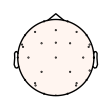

In [184]:
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs_plot, epochs=preproc_S1)

### Visulization of inter-brain links projected
on either 2D or 3D head models

It can be applied to Cohen’s D (C as done here) or statistical values (statscondCluster.F_obs or F_obs_plot) of inter-individual brain connectivity

We can defining manually bad channel for viz test:

In [185]:
epo1.info['bads'] = ['F8', 'Fp2', 'Cz', 'O2']
epo2.info['bads'] = ['F7', 'O1']

### Visualisation of brain connectivity in 2D and 3D
Defining head model and adding sensors

Warning, threshold='auto' must be used carefully, it is calculated specifically for the dyad, and therefore does not allow comparability between different dyads.

#### Visualization of inter-brain connectivity in 2D

Inter-brain Hilbert-based connectivity

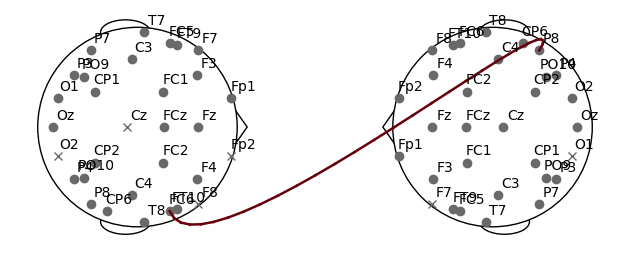

<Axes: >

In [187]:
viz.viz_2D_topomap_inter(epo1, epo2, C, threshold=3, steps=30, lab=True)

Inter-brain VAR-based connectivity (information flow from participant 1 to participant 2)

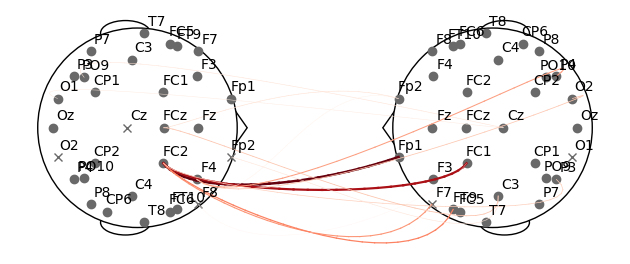

<Axes: >

In [189]:
viz.viz_2D_topomap_inter(epo1, epo2, no_ICA_result_inter[0], threshold=3, steps=30, lab=True)

Inter-brain VAR-based connectivity (information flow from participant 2 to participant 1)

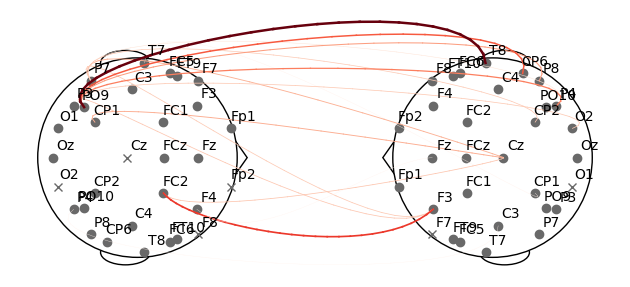

<Axes: >

In [192]:
viz.viz_2D_topomap_inter(epo1, epo2, no_ICA_result_inter[1], threshold=3, steps=30, lab=True)

#### Visualization of inter-brain connectivity in 3D

Inter-brain Hilbert-based connectivity


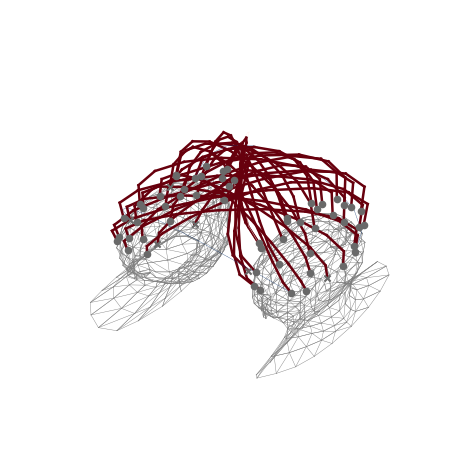

<Axes3D: >

In [259]:
viz.viz_3D_inter(epo1, epo2, C, threshold='auto', steps=10, lab=False)

Inter-brain VAR-based connectivity (information flow from participant 1 to participant 2)

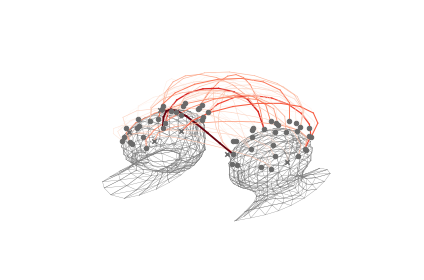

In [143]:
viz.viz_3D_inter(epo1, epo2, no_ICA_result_inter[0], threshold='auto', steps=10, lab=False)

Inter-brain VAR-based connectivity (information flow from participant 2 to participant 1)

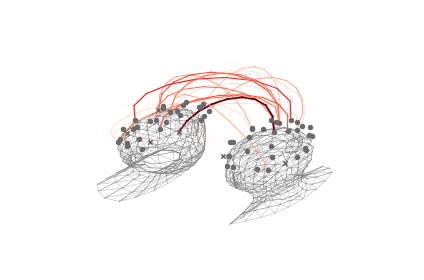

In [144]:
viz.viz_3D_inter(epo1, epo2, no_ICA_result_inter[1], threshold='auto', steps=10, lab=False)

#### Visualization of intra-brain connectivity in 2D

Intra-brain Hilbert-based connectivity

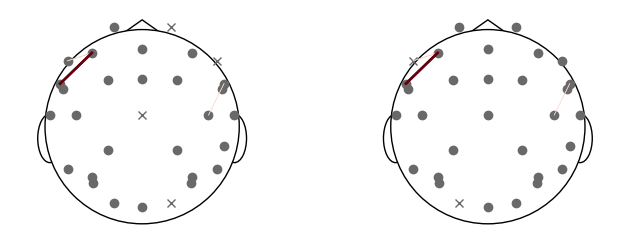

<Axes: >

In [234]:
viz.viz_2D_topomap_intra(epo1, epo2,
                         C1= result_intra[0],
                         C2= result_intra[1],
                         threshold='auto',
                         steps=2,
                         lab=False)

Intra-brain VAR-based connectivity

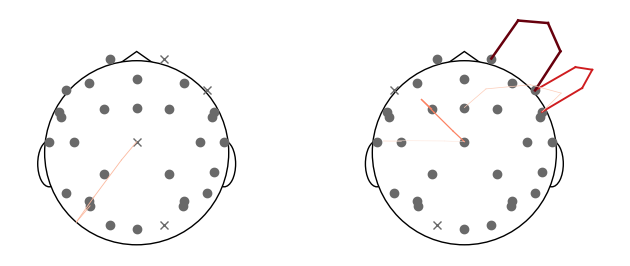

<Axes: >

In [263]:
viz.viz_2D_topomap_intra(epo1, epo2,
                         C1= no_ICA_result_intra[0],
                         C2= no_ICA_result_intra[1],
                         threshold=5,
                         steps=5,
                         lab=False)

#### Visualization of intra-brain connectivity in 3D

Intra-brain Hilbert-based connectivity

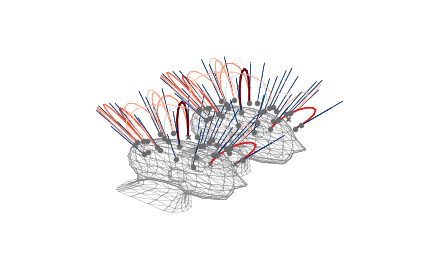

In [74]:
viz.viz_3D_intra(epo1, epo2,
                 C1= result_intra[0],
                 C2= result_intra[1],
                 threshold='auto',
                 steps=10,
                 lab=False)

Intra-brain VAR-based connectivity

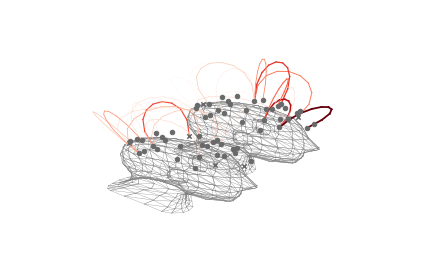

In [75]:
viz.viz_3D_intra(epo1, epo2,
                 C1= no_ICA_result_intra[0],
                 C2= no_ICA_result_intra[1],
                 threshold='auto',
                 steps=10,
                 lab=False)